In [1]:
import json
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import jaccard_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AgglomerativeClustering

#https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
import geopandas as gpd
from geopandas.tools import sjoin

In this 

# Load yelp datasets

In [2]:
cities = {}
categories = {}
with open('yelp_dataset/business.json') as f:
    for cnt, line in enumerate(f):
        d = json.loads(line)
        c = d['city']
        ca = d['categories']
        if ca:
            for cat in ca.replace(' ','').split(','):
                if cat in categories:
                    categories[cat]+=1
                else:
                    categories[cat]=1
        if c in cities:
            cities[c]+=1
        else:
            cities[c]=1

In [3]:
list(islice({k: v for k, v in sorted(cities.items(), key=lambda item: -item[1])}.items(),4))

[('Las Vegas', 29370),
 ('Toronto', 18906),
 ('Phoenix', 18766),
 ('Charlotte', 9509)]

In [4]:
list(islice({k: v for k, v in sorted(categories.items(), key=lambda item: -item[1])}.items(),10))

[('Restaurants', 59371),
 ('Shopping', 31878),
 ('Food', 29989),
 ('HomeServices', 19729),
 ('Beauty&Spas', 19370),
 ('Health&Medical', 17171),
 ('LocalServices', 13932),
 ('Automotive', 13203),
 ('Nightlife', 13095),
 ('Bars', 11341)]

In [5]:
useful_cats = [a[0] for a in list(islice({k: v for k, v in sorted(categories.items(), key=lambda item: -item[1])}.items(),400))]

In [6]:
biz_list = []
with open('yelp_dataset/business.json') as f:
    for cnt, line in enumerate(f):
        d = json.loads(line)
        c = d['city']
        ca = d['categories']
        lat = d['latitude']
        lon = d['longitude']
        if c in ('Toronto','Phoenix') and ca:
            ca_fix = ':'.join(sorted([c for c in d['categories'].replace(' ','').split(',') if c in useful_cats]))
            biz_list.append([d['business_id'],c, ca_fix, lat, lon])
biz_df = pd.DataFrame(biz_list,columns=['biz_id','city','categories','lat','lon'])         

In [7]:
print(f"number of businesses in both cities = {biz_df.shape[0]}")

number of businesses in both cities = 37575


In [8]:
biz_df.head()

,biz_id,city,categories,lat,lon
0,1SWheh84yJXfytovILXOAQ,Phoenix,ActiveLife:Golf,33.522143,-112.018481
1,1Dfx3zM-rW4n-31KeC8sJg,Phoenix,Breakfast&Brunch:FastFood:Mexican:Restaurants:...,33.495194,-112.028588
2,zSpQmEBvRe3IhTUlMSA6HQ,Toronto,ActiveLife:Fitness&Instruction:Gyms:Health&Med...,43.645041,-79.395799
3,C9oCPomVP0mtKa8z99E3gg,Toronto,Bakeries:Food,43.754093,-79.349548
4,C9keC4mWuXdl2mYFHZXudQ,Toronto,Fashion:Men'sClothing:Shopping:SportingGoods:S...,43.670744,-79.391385


For later use we'll convert the categories to one hot encoding

In [9]:
cats = biz_df['categories'].str.get_dummies(sep=':')
cat_cols = cats.columns.tolist()

In [10]:
df_fin = pd.concat([biz_df,cats],axis=1)
df_fin['ind']=range(df_fin.shape[0])
df_biz = df_fin[['ind','biz_id','city','lat','lon']].drop_duplicates().sort_values('biz_id')

# Display SVG maps of toronto and phoenix neighborhoods
We'll start by merging the lat/lon points of yelp businesses with a map of Phoenix by neighborhood

In [11]:
phx = df_biz.loc[df_biz['city']=='Phoenix'].copy()

In [12]:
#http://mapping-phoenix.opendata.arcgis.com/
phx_map = gpd.read_file('phoenix_map/Villages.shp').to_crs('EPSG:4326')
phx_map['colors']=range(phx_map.shape[0])
phx_map['coords'] = phx_map['geometry'].apply(lambda x: x.representative_point().coords[:])
phx_map['coords'] = [coords[0] for coords in phx_map['coords']]
phx_map['name']=phx_map['NAME']
phx_map = phx_map.loc[phx_map['name']!='Rio Vista']

In [13]:
phx_points = gpd.GeoDataFrame(phx,geometry = gpd.points_from_xy(phx['lon'],phx['lat']))
phx_points = sjoin(phx_points, phx_map, how='left')

/opt/anaconda3/envs/cities/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


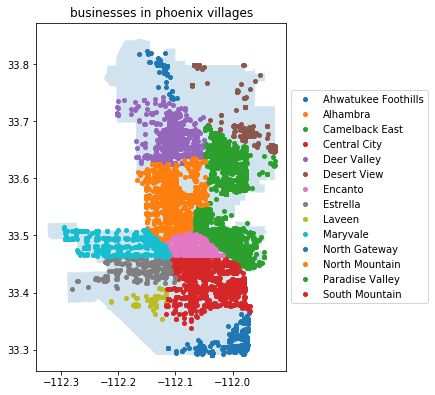

In [14]:
fig, ax = plt.subplots(figsize=(15,8))

phx_map.plot(ax=ax,alpha=0.2)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in phx_points.groupby('name'):
    ax.plot(group['lon'], group['lat'], marker='o', linestyle='', ms=4, label=name)
plt.title('businesses in phoenix villages')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Same map for toronto

In [15]:
tor = df_biz.loc[df_biz['city']=='Toronto'].copy()

In [16]:
# https://open.toronto.ca/dataset/neighbourhoods/
tor_map = gpd.read_file('toronto_wards.geojson')
# url = "https://gist.githubusercontent.com/jasonicarter/639c7f839c9c6e8c02a8eea9ac4bd1b0/raw/d6de8b89bfe38b0a2b0105f60038688259106a35/toronto_topo.json"
# tor_map = gpd.read_file(url)
tor_map['colors']=range(tor_map.shape[0])
tor_map['coords'] = tor_map['geometry'].apply(lambda x: x.representative_point().coords[:])
tor_map['coords'] = [coords[0] for coords in tor_map['coords']]
tor_map['name']=tor_map['AREA_NAME']
# tor_map['name']=tor_map['name'].apply(lambda x: x.replace(' ','\n').replace('-','\n').replace('/','/\n').split('(')[0])

In [17]:
# https://gis.stackexchange.com/questions/282681/filter-a-geopandas-dataframe-for-points-within-a-specific-country
# https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
tor_points = gpd.GeoDataFrame(tor,geometry = gpd.points_from_xy(tor['lon'],tor['lat']))
tor_points = sjoin(tor_points, tor_map, how='left')

/opt/anaconda3/envs/cities/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


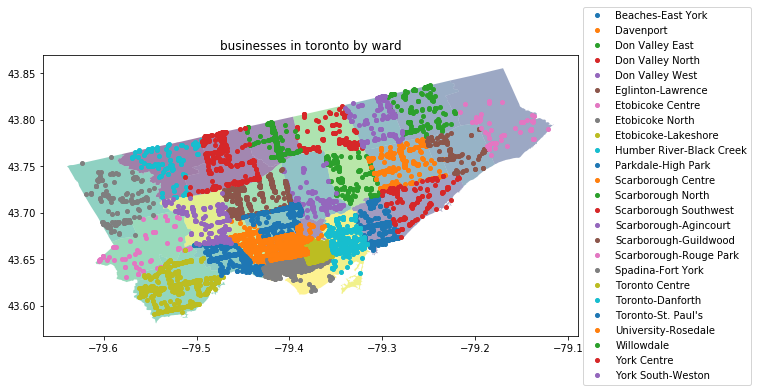

In [18]:
fig, ax = plt.subplots(figsize=(12,10))

tor_map.plot(ax=ax,alpha=0.5,cmap='viridis')

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in tor_points.groupby('name'):
    ax.plot(group['lon'], group['lat'], marker='o', linestyle='', ms=4, label=name)
plt.title('businesses in toronto by ward')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Finally lets draw Phoenix and Toronto on one figure with their own colors

We'll store this figure as an SVG to pull from in the web viz

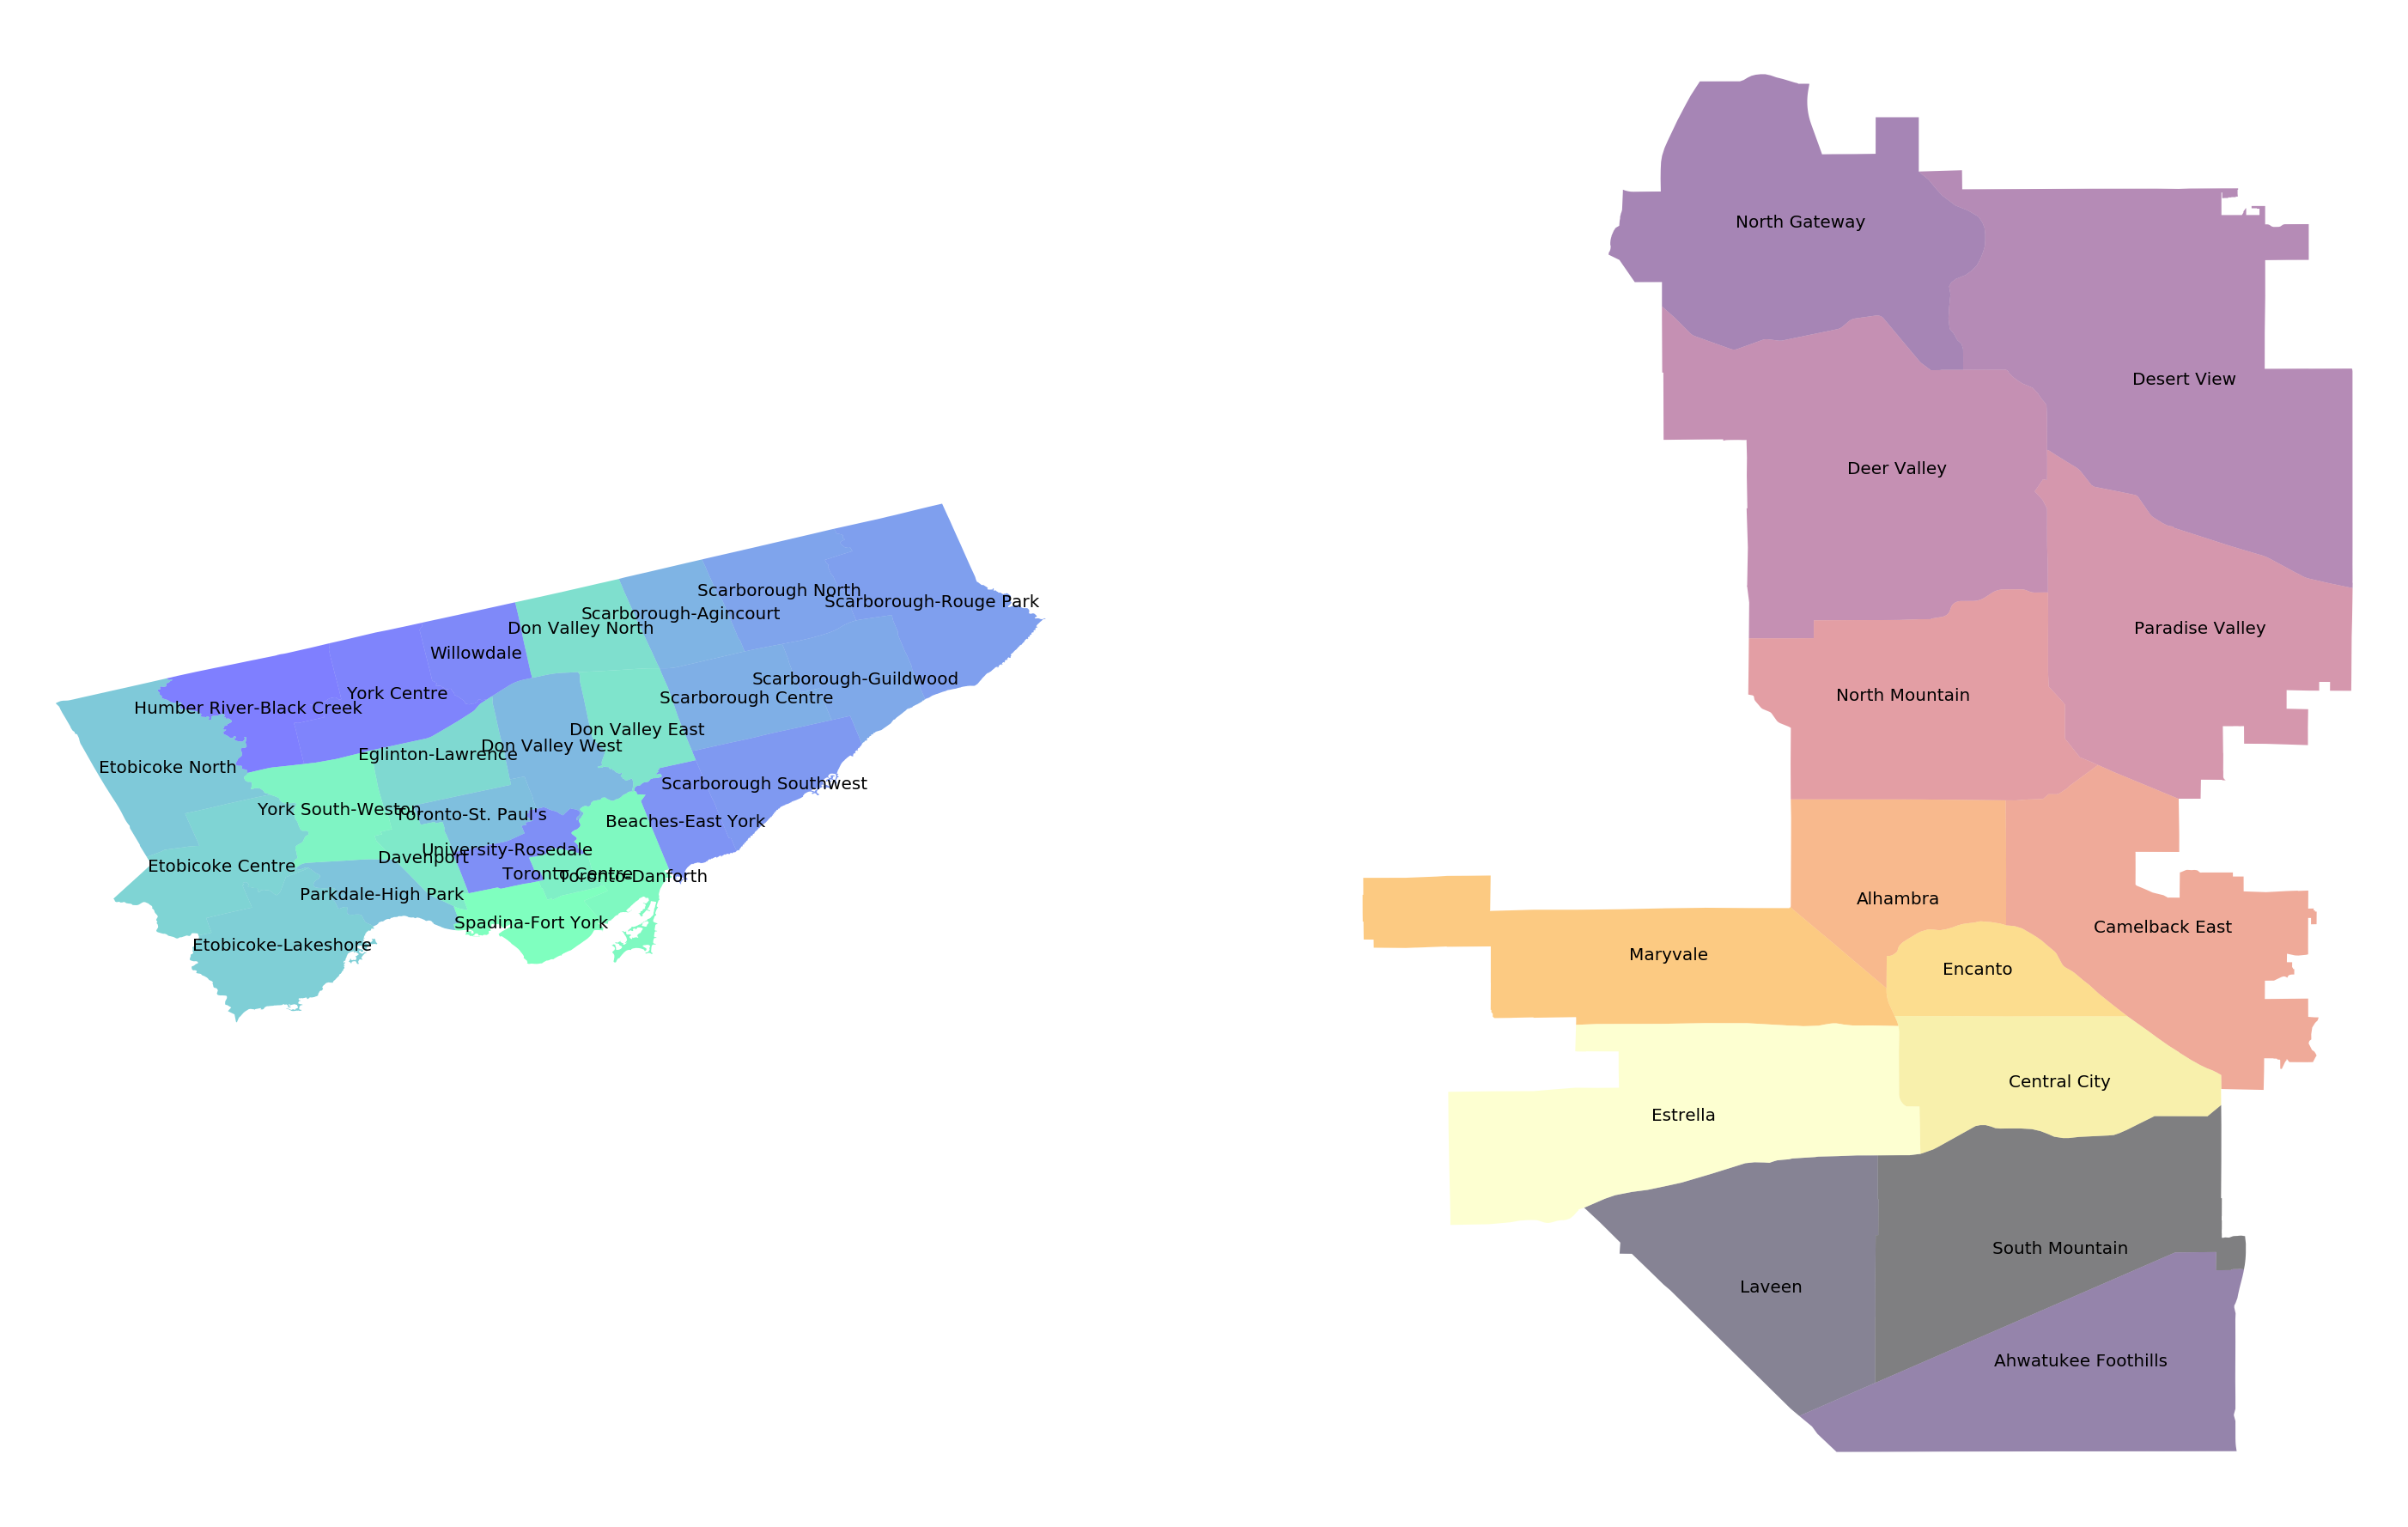

In [19]:
fig, axs = plt.subplots(1,2,figsize=(50,50))
ax=axs[0]
tor_map.plot(ax=ax,alpha=0.5,cmap='winter')

for idx, row in tor_map.iterrows():
    ax.annotate(s=row['name'], xy=row['coords'], fontsize=20,
                 horizontalalignment='center',verticalalignment='center')
ax.axis('off')

ax=axs[1]
phx_map.plot(ax=ax,alpha=0.5,cmap='inferno')

for idx, row in phx_map.iterrows():
    ax.annotate(s=row['name'], xy=row['coords'], fontsize=20,
                 horizontalalignment='center',verticalalignment='center')
ax.axis('off')

fig.patch.set_visible(False)
plt.savefig("maps.svg", format="svg")
plt.show()

# Building the structure of the D3 force graph

We're going to try to position the neighborhoods on the map using a D3 force graph.  To do that, I need to balance three competing forces.

1. Toronto's neighborhoods fixed straight to the map
2. Phoenix's neighborhoods fixed by distance to each other
3. Toronto and Phoenix's neighborhoods pulled together by their neighborhood similarity

I'll break them down in that order

## Toronto fixed to the map by lat/lon
This is by far the easiest. I will just be recording the centerpoint of the lat/lon for a given neighborhood in toronto.

In [20]:
t_i_clusts = []
t_i_x = []
t_i_y = []
for name_i, group_i in tor_map.groupby('name'):
    i_coords = np.array([group_i['coords'].values[0]])
    t_i_clusts.append(name_i)
    t_i_x.append(i_coords[0][0])
    t_i_y.append(i_coords[0][1])

df_cl_t = pd.DataFrame(list(zip(t_i_clusts,t_i_x,t_i_y)),
                       columns=['name','x','y']) 

## Phoenix fixed by nighborhood to neighborhood distance

I want phoenix to be able to freely rotate, so instead of fixing latitude and longitude, I'll be fixing the distance between centerpoints of each neighborhood.  The D3 force graph will then have a bunch of connecting link forces that try to constrain the map to keep its original shape.

In [21]:
p_i_clusts = []
p_j_clusts = []
p_i_x = []
p_i_y = []
p_dists = []

for name_i, group_i in phx_map.groupby('name'):
    for name_j, group_j in phx_map.groupby('name'):
        i_coords = np.array([group_i['coords'].values[0]])
        j_coords = np.array([group_j['coords'].values[0]])
        dist = cdist(i_coords,j_coords)[0][0]
        p_i_clusts.append(name_i)
        p_j_clusts.append(name_j)
        p_i_x.append(i_coords[0][0])
        p_i_y.append(i_coords[0][1])
        p_dists.append(dist)

df_cl_p = pd.DataFrame(list(zip(p_i_clusts,p_j_clusts,p_dists,p_i_x,p_i_y)),
                       columns=['p_i_clust','p_j_clust','dist','x','y']) 


## Calculating Similarity between Toronto and Phoenix neighborhoods
Now comes the part that requires some finesse.  I played around with a few distance metrics.  For now, let's just go with euclidean distance.

In [22]:
cat_arr = cats.values

In [23]:
t_clusts = []
p_clusts = []
dists = []
for name_t, group_t in tor_points.groupby('name'):
    for name_p, group_p in phx_points.groupby('name'):
        cat_t = cat_arr[group_t['ind'],:].sum(axis=0,keepdims=True)
        cat_p = cat_arr[group_p['ind'],:].sum(axis=0,keepdims=True)
#         dist = cosine_similarity(cat_t,cat_p)
        dist= euclidean_distances(cat_t,cat_p)
#         sim = jaccard_score(cat_t,cat_p,average='weighted')
#         sim = S[np.ix_(group_t['ind'],group_p['ind'])].mean()
        t_clusts.append(name_t)
        p_clusts.append(name_p)
        dists.append(dist[0][0])
df_cl = pd.DataFrame(list(zip(t_clusts,p_clusts,dists)),columns=['t_clust','p_clust','dist'])
df_cl['sim']=1-df_cl['dist']/df_cl['dist'].max()

In [24]:
def convert_to_matrix(cl_df,sim_col):
    t_inds = cl_df['t_clust'].unique()
    p_inds = cl_df['p_clust'].unique()
    viz = np.zeros([len(t_inds),len(p_inds)])
    for t_i, t_ind in enumerate(t_inds):
        for p_i, p_ind in enumerate(p_inds):
            viz[t_i,p_i] = cl_df.loc[(cl_df['t_clust']==t_ind) & (cl_df['p_clust']==p_ind), sim_col]
    return viz

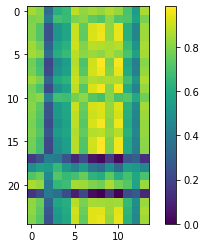

In [25]:
plt.imshow(convert_to_matrix(df_cl,'sim'))
plt.colorbar()

this looks like a standard similarity matrix.  unfortunately, this (and any other similarity metric) suffer from a fundamental problem:
> a few neighborhoods will end up being more similar to lots of other neighborhoods

In this example, it's clear that there are blue stripes for highly unsimiliar neighborhoods, and then there are lots of yellow stripes for neighborhoods that are pretty much the same as everybody else.

This doesn't seem like too much of an issue except that in the visualization this meant that those neighborhoos would be pulled into the center and then the other map would try to compress itself down so everything mapped to one neighborhood.  That isn't good at all.

Instead, I came up with a heuristic renormalization technique.  It needs work, but it's OK for now.

In [26]:
p_list = []
t_list = []
f = 0.1
for tst_i in range(10):
    df_cl_tst = df_cl.copy()
    for run_i in range(5):
        for rand_ind in np.random.permutation(range(df_cl_tst.shape[0])):
        
            row = df_cl_tst.iloc[rand_ind]
            t_inds = df_cl_tst['t_clust']==row['t_clust']
            p_inds = df_cl_tst['p_clust']==row['p_clust']

            tgo = df_cl_tst.loc[t_inds,'sim']
            tout = np.empty(tgo.size,dtype=np.int64)
            tout[tgo.argsort()] = np.arange(tgo.size)
            tout = tout/tout.max()

            pgo = df_cl_tst.loc[p_inds,'sim']
            pout = np.empty(pgo.size,dtype=np.int64)
            pout[pgo.argsort()] = np.arange(pgo.size)
            pout = pout/pout.max()

            if np.random.randn()>0:
                df_cl_tst.loc[t_inds,'sim'] = (1-f)*df_cl_tst.loc[t_inds,'sim']+f*tout
                df_cl_tst.loc[p_inds,'sim'] = (1-f)*df_cl_tst.loc[p_inds,'sim']+f*pout
            else:
                df_cl_tst.loc[p_inds,'sim'] = (1-f)*df_cl_tst.loc[p_inds,'sim']+f*pout
                df_cl_tst.loc[t_inds,'sim'] = (1-f)*df_cl_tst.loc[t_inds,'sim']+f*tout
    
    df_cl_tst[f'sim_{tst_i}'] = df_cl_tst['sim']
    df_cl = df_cl.merge(df_cl_tst[['t_clust','p_clust',f'sim_{tst_i}']],on=['t_clust','p_clust'])
df_cl['sim_avg'] = df_cl[[f'sim_{tst_i}' for tst_i in range(10)]].mean(axis=1)

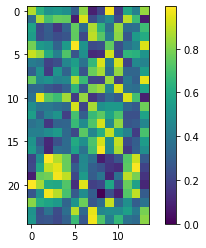

In [27]:
plt.imshow(convert_to_matrix(df_cl,'sim_avg'))
plt.colorbar()

this has the desirable property of having a lot more heterogeneity in similarity.  This means only a few neighborhoods will be mapped onto each other at a time, and we should see real distortion and warping.

# Converting constraint DFs to D3 json
now, with these three constraints, we can format the data for use in D3. First, i do some normalization to prep for going to HTML land.

In [28]:
df_cl_t['source'] = df_cl_t['name'].apply(str)
df_cl['source'] = df_cl['p_clust'].apply(str)
df_cl['target'] = df_cl['t_clust'].apply(str)
df_cl_p['source'] = df_cl_p['p_i_clust'].apply(str)
df_cl_p['target'] = df_cl_p['p_j_clust'].apply(str)

df_cl['type'] = 1
df_cl_t['type'] = 0
df_cl_p['type'] = 0

df_cl['mobile'] = 0
df_cl_t['mobile'] = 0
df_cl_p['mobile'] = 1

length_scale = tor_map.bounds['maxy'].max()-tor_map.bounds['miny'].min()
df_cl_t['x'] = (df_cl_t['x']-tor_map.bounds['minx'].min())/length_scale
df_cl_t['y'] = (df_cl_t['y']-tor_map.bounds['miny'].min())/length_scale

length_scale = phx_map.bounds['maxy'].max()-phx_map.bounds['miny'].min()
df_cl_p['x'] = (df_cl_p['x']-phx_map.bounds['minx'].min())/length_scale
df_cl_p['y'] = (df_cl_p['y']-phx_map.bounds['miny'].min())/length_scale


df_cl_p['dist'] = df_cl_p['dist']/length_scale

### Finally, we convert dataframes into a node_list and a link_list in json

In [29]:
df_cl_combo = pd.concat([df_cl_t,df_cl_p],axis=0,sort=False)
df_cl_combo = df_cl_combo.fillna(-1)

unique_ips = df_cl_combo[['source','x','y','mobile']].drop_duplicates().set_index('source')

df_cl_combo = pd.concat([df_cl,df_cl_p],axis=0,sort=False)
df_cl_combo = df_cl_combo.fillna(-1)

links_list = list(df_cl_combo.apply(lambda row: {"source": unique_ips.index.get_loc(row['source']), 
                                                      "target": unique_ips.index.get_loc(row['target']), 
                                                      "dist": row['dist'], 
                                                      "sim": row['sim_avg'], 
                                                      "type": row['type'], 
                                                      "mobile": row['mobile']}, axis=1))
print('links made')
nodes_list = []
for ip in unique_ips.index:
    nodes_list.append({"name":ip, 
                       "group": unique_ips.index.get_loc(ip), 
                       "xo": unique_ips.loc[ip,'x'],
                       "yo": unique_ips.loc[ip,'y'],
                       "mobile": float(unique_ips.loc[ip,'mobile']),
                      })
print('nodes made')
json_prep = {"nodes":nodes_list, "links":links_list}
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)

with open('city_export.json','w') as f:
    f.write(json_dump)
    

links made
nodes made
